In [137]:
### import stuff
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.utils.data import TensorDataset, DataLoader
from torchsummary import summary
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import time




In [138]:
### Define function

def f(x,y):
    ### Choose function
    z =  np.power(x, 2) + np.power(y, 2)
    # z = np.sin(x/5) + np.cos(y/5)
    #z = np.sqrt(x**2 + y**2)
    #z =  10 * np.power(x, 2) + np.power(y, 3)
    #z = x + y

    ### Normalize function output to have range between -10 and 10
    z = z / np.max(np.abs(z)) 

    return z

Text(0.5, 0, 'z')

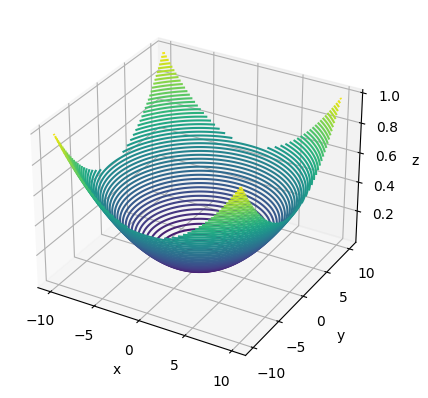

In [139]:
# Plot function

x = np.linspace(-10, 10, 100)
y = np.linspace(-10, 10, 100)
X, Y = np.meshgrid(x, y)
Z = f(X, Y)


ax = plt.axes(projection = '3d')
ax.contour3D(X, Y, Z, 50)#, cmap='binary')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')


In [140]:
### Create dataset by random sampling

input = np.random.random([10000, 2]) * 20 - 10
output = f(input[:, 0], input[:, 1])

tensor_input = torch.Tensor(input)
tensor_output = torch.Tensor(output)

dataset = TensorDataset(tensor_input, tensor_output)
dataloader = DataLoader(dataset, batch_size=1)

In [141]:
# Define neural network

# Define neural network
class Net(nn.Module):
    def __init__(self):
        super().__init__()

        n_in = 2 # input, x and y
        n1 = 10
        n2 = 10
        n3 = 10
        n_out = 1 # output, z

        self.fc1 = nn.Linear(n_in, n1)
        self.fc2 = nn.Linear(n1, n2)
        self.fc3 = nn.Linear(n2, n3)
        self.fc4 = nn.Linear(n3, n_out)
        
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x)) 
        x = F.relu(self.fc3(x))
        
        x = self.fc4(x) # Linear activation for final layer
        return x


net = Net()
summary(net, (1, 2))
print(net)


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                [-1, 1, 10]              30
            Linear-2                [-1, 1, 10]             110
            Linear-3                [-1, 1, 10]             110
            Linear-4                 [-1, 1, 1]              11
Total params: 261
Trainable params: 261
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.00
Estimated Total Size (MB): 0.00
----------------------------------------------------------------
Net(
  (fc1): Linear(in_features=2, out_features=10, bias=True)
  (fc2): Linear(in_features=10, out_features=10, bias=True)
  (fc3): Linear(in_features=10, out_features=10, bias=True)
  (fc4): Linear(in_features=10, out_features=1, bias=True)
)


In [142]:
### Loss function and optimizer

#criterion = nn.CrossEntropyLoss()
criterion = nn.MSELoss() # MSE loss for regresssion problems
#optimizer = optim.SGD(net.parameters(), lr=0.0001, momentum = 0.5) 
optimizer = optim.RMSprop(net.parameters(), lr=0.0001)


losses = []

[1,  2500] loss: 0.088
[1,  5000] loss: 0.008
[1,  7500] loss: 0.003
[1, 10000] loss: 0.002
[2,  2500] loss: 0.002
[2,  5000] loss: 0.002
[2,  7500] loss: 0.002
[2, 10000] loss: 0.002
[3,  2500] loss: 0.002
[3,  5000] loss: 0.001
[3,  7500] loss: 0.001
[3, 10000] loss: 0.001
[4,  2500] loss: 0.001
[4,  5000] loss: 0.000
[4,  7500] loss: 0.000
[4, 10000] loss: 0.000
[5,  2500] loss: 0.000
[5,  5000] loss: 0.000
[5,  7500] loss: 0.000
[5, 10000] loss: 0.000
Finished training after:  23.4 seconds
traintime  20.0, ratio:  0.86


Text(0.5, 0, 'Iteration')

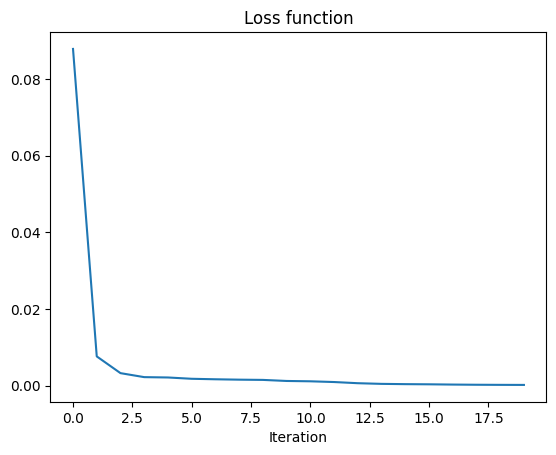

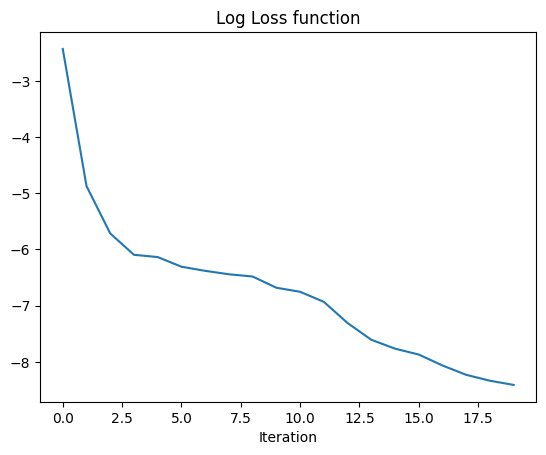

In [143]:
### Train network
traintime = 0.0
tic = time.time()
for epoch in range(5):
    running_loss = 0.0
    length = dataloader.__len__()
    for i, data in enumerate(dataloader, 0):
        inputs, labels = data
        # set parameter gradients to zero
        optimizer.zero_grad()

        # forwardprop, backprop, and update parameters
        traintic = time.time()
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        traintoc = time.time()
        traintime += traintoc-traintic

        # Print statistics
        running_loss += loss.item()
        if i % (length/4) == (length/4)-1:
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / (length/4):.3f}')
            losses.append(running_loss / (length/4))
            running_loss = 0.0
toc = time.time()
print(f'Finished training after: {toc - tic : .1f} seconds')
print(f'traintime {traintime : .1f}, ratio: {traintime / (toc-tic) : .2f}')

plt.plot(losses)
plt.title('Loss function')
plt.xlabel('Iteration')
plt.figure()

plt.plot(np.log(losses))
plt.title('Log Loss function')
plt.xlabel('Iteration')

Text(0.5, 0.92, 'Estimate')

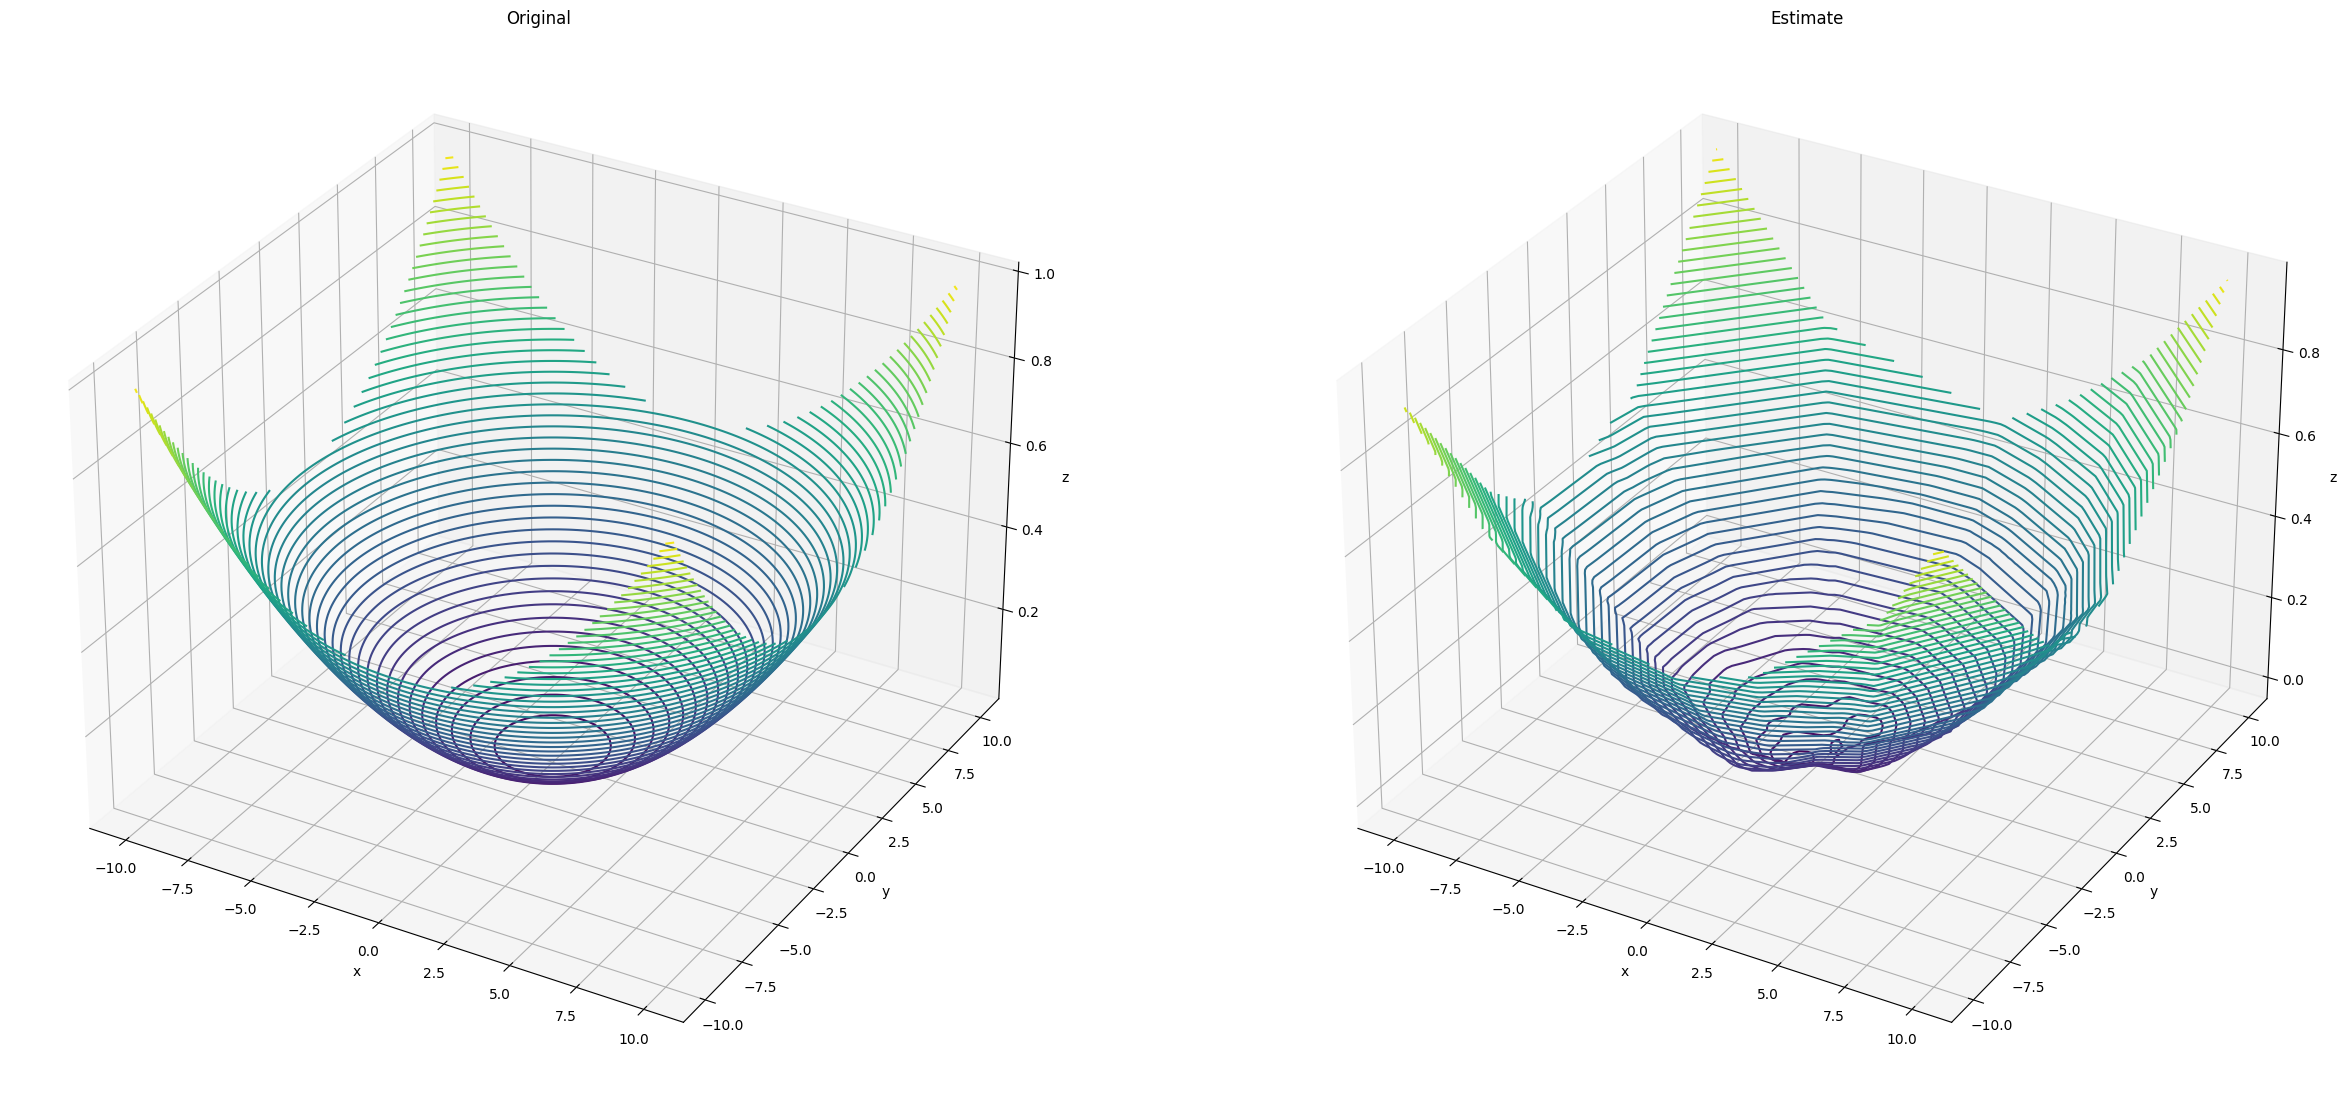

In [144]:
x = np.linspace(-10, 10, 100)
y = np.linspace(-10, 10, 100)
X, Y = np.meshgrid(x, y)

X_flat = np.matrix(X.ravel()).transpose()
Y_flat = np.matrix(Y.ravel()).transpose()


XY = np.append(X_flat, Y_flat, axis=1)

### Generate NN output
output = net(torch.Tensor(XY))

Z_est = output.detach().numpy().transpose()
Z_est = np.reshape(Z_est, X.shape)


### Plot
fig = plt.figure(figsize=[30, 20])
ax = fig.add_subplot(1, 2, 1, projection='3d')

ax.contour3D(X, Y, f(X, Y), 50)#, cmap='binary')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
ax.set_title('Original')

ax = fig.add_subplot(1, 2, 2, projection='3d')

ax.contour3D(X, Y, Z_est, 50)#, cmap='binary')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
ax.set_title('Estimate')
